##  Custom regression models

Like for univariate models, it is possible to create your own custom parametric survival models. Why might you want to do this? 

 - Create new / extend AFT models using known probability distributions
 - Create a piecewise model using domain knowledge about subjects
 - Iterate and fit a more accurate parametric model

*lifelines* has a very simple API to create custom parametric regression models. You only need to define the cumulative hazard function. For example, the cumulative hazard for the constant-hazard regression model looks like:

$$ 
H(t, x) = \frac{t}{\lambda(x)}\\ \lambda(x) = \exp{(\vec{\beta} \cdot \vec{x}^{\,T})}
$$ 

where $\beta$ are the unknowns we will optimize over. 


Below are some example custom models.

In [1]:
from lifelines.fitters import ParametricRegressionFitter
from autograd import numpy as np
from lifelines.datasets import load_rossi


class ExponentialAFTFitter(ParametricRegressionFitter):
    
    # this class property is necessary, and should always be a non-empty list of strings. 
    _fitted_parameter_names = ['lambda_']
    
    def _cumulative_hazard(self, params, t, Xs):
        # params is a dictionary that maps unknown parameters to a numpy vector. 
        # Xs is a dictionary that maps unknown parameters to a numpy 2d array 
        beta = params['lambda_']
        X = Xs['lambda_']
        lambda_ = np.exp(np.dot(X, beta))
        return t / lambda_
    

rossi = load_rossi()
rossi['intercept'] = 1.0

# the below variables maps dataframe columns to parameters
regressors = {
    'lambda_': rossi.columns
}

eaf = ExponentialAFTFitter().fit(rossi, 'week', 'arrest', regressors=regressors)
eaf.print_summary()

Text(0.5, 1.0, 'Predicted survival functions for selected subjects')

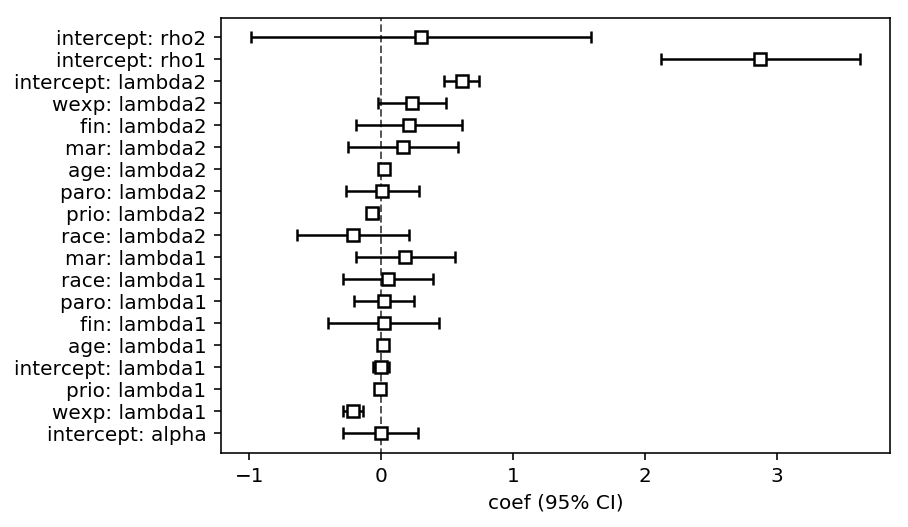

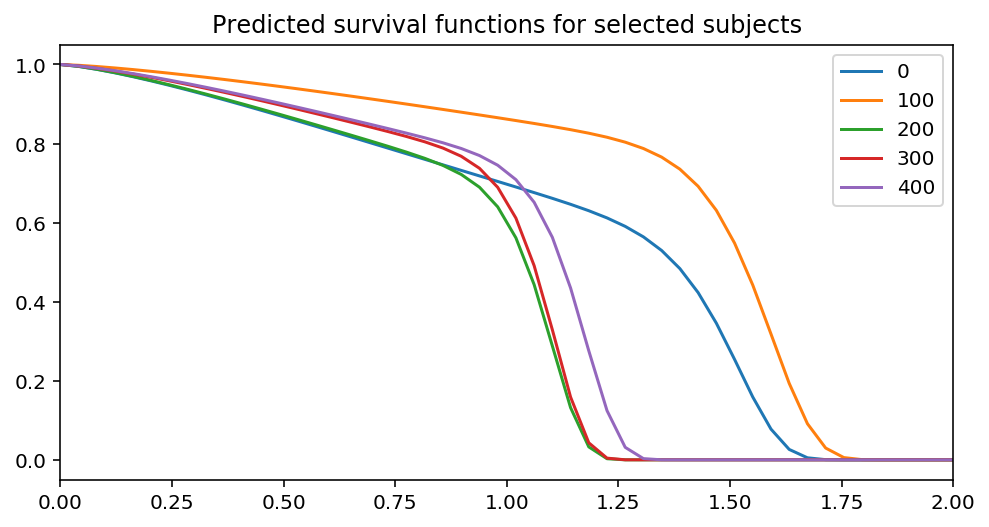

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

class DependentCompetingRisksHazard(ParametricRegressionFitter):
    """

    Reference
    --------------
    Frees and Valdez, UNDERSTANDING RELATIONSHIPS USING COPULAS
    
    """
    
    _fitted_parameter_names = ["lambda1", "rho1", "lambda2", "rho2", "alpha"]

    def _cumulative_hazard(self, params, T, Xs):
        lambda1 = np.exp(np.dot(Xs["lambda1"], params["lambda1"]))
        lambda2 = np.exp(np.dot(Xs["lambda2"], params["lambda2"]))
        rho2 =    np.exp(np.dot(Xs["rho2"],    params["rho2"]))
        rho1 =    np.exp(np.dot(Xs["rho1"],    params["rho1"]))
        alpha =   np.exp(np.dot(Xs["alpha"],   params["alpha"]))

        return ((T / lambda1) ** rho1 + (T / lambda2) ** rho2) ** alpha


fitter = DependentCompetingRisksHazard(penalizer=0.1)

rossi = load_rossi()
rossi["intercept"] = 1.0
rossi["week"] = rossi["week"] / rossi["week"].max() # scaling often helps with convergence

covariates = {
    "lambda1": rossi.columns,
    "lambda2": rossi.columns,
    "rho1": ["intercept"],
    "rho2": ["intercept"],
    "alpha": ["intercept"],
}

fitter.fit(rossi, "week", event_col="arrest", regressors=covariates, timeline=np.linspace(0, 2))
fitter.print_summary(2)

ax = fitter.plot()

ax = fitter.predict_survival_function(rossi.loc[::100]).plot(figsize=(8, 4))
ax.set_title("Predicted survival functions for selected subjects")

### Cure models

Suppose in our population we have a subpopulation that will never experience the event of interest. Or, for some subjects the event will occur so far in the future that it's essentially at time infinity. In this case, the survival function for an individual should not asymptically approach zero, but _some positive value_. Models that describe this are sometimes called cure models (i.e. the subject is "cured" of death and hence no longer susceptible) or time-lagged conversion models. 

It would be nice to be able to use common survival models _and_ have some "cure" component. Let's suppose that for individuals that will experience the event of interest, their survival distrubtion is a Weibull, denoted $S_W(t)$. For a random selected individual in the population, thier survival curve, $S(t)$, is:

$$ 
\begin{align*}
S(t) = P(T > t) &= P(\text{cured}) P(T > t\;|\;\text{cured}) +  P(\text{not cured}) P(T > t\;|\;\text{not cured})  \\
      &= p + (1-p) S_W(t)
\end{align*}
$$

Even though it's in an unconvential form, we can still determine the cumulative hazard (which is the negative logarithm of the survival function):

$$ H(t) =  -\log{\left(p + (1-p) S_W(t)\right)} $$

In [9]:
from autograd.scipy.special import expit

class CureModel(ParametricRegressionFitter):
    _scipy_fit_method = "SLSQP"
    _scipy_fit_options = {"ftol": 1e-10, "maxiter": 200}

    _fitted_parameter_names = ["lambda_", "beta_", "rho_"]

    def _cumulative_hazard(self, params, T, Xs):
        c = expit(np.dot(Xs["beta_"], params["beta_"]))

        lambda_ = np.exp(np.dot(Xs["lambda_"], params["lambda_"]))
        rho_ = np.exp(np.dot(Xs["rho_"], params["rho_"]))
        sf = np.exp(-(T / lambda_) ** rho_)

        return -np.log((1 - c) + c * sf)


cm = CureModel(penalizer=0.0)

rossi = load_rossi()
rossi["intercept"] = 1.0

covariates = {"lambda_": rossi.columns, "rho_": ["intercept"], "beta_": ['intercept', 'fin']}

cm.fit(rossi, "week", event_col="arrest", regressors=covariates, timeline=np.arange(250)) 
cm.print_summary(2)

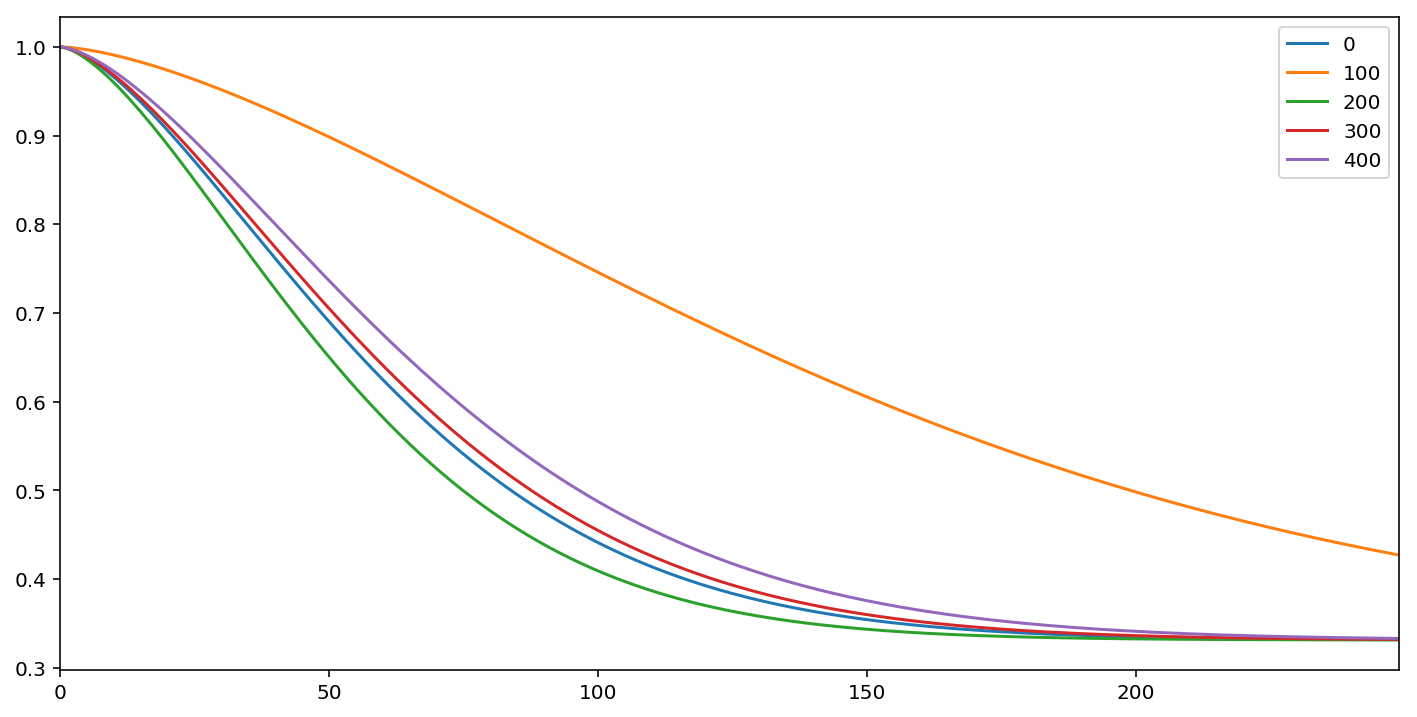

In [18]:
cm.predict_survival_function(rossi.loc[::100]).plot(figsize=(12,6))

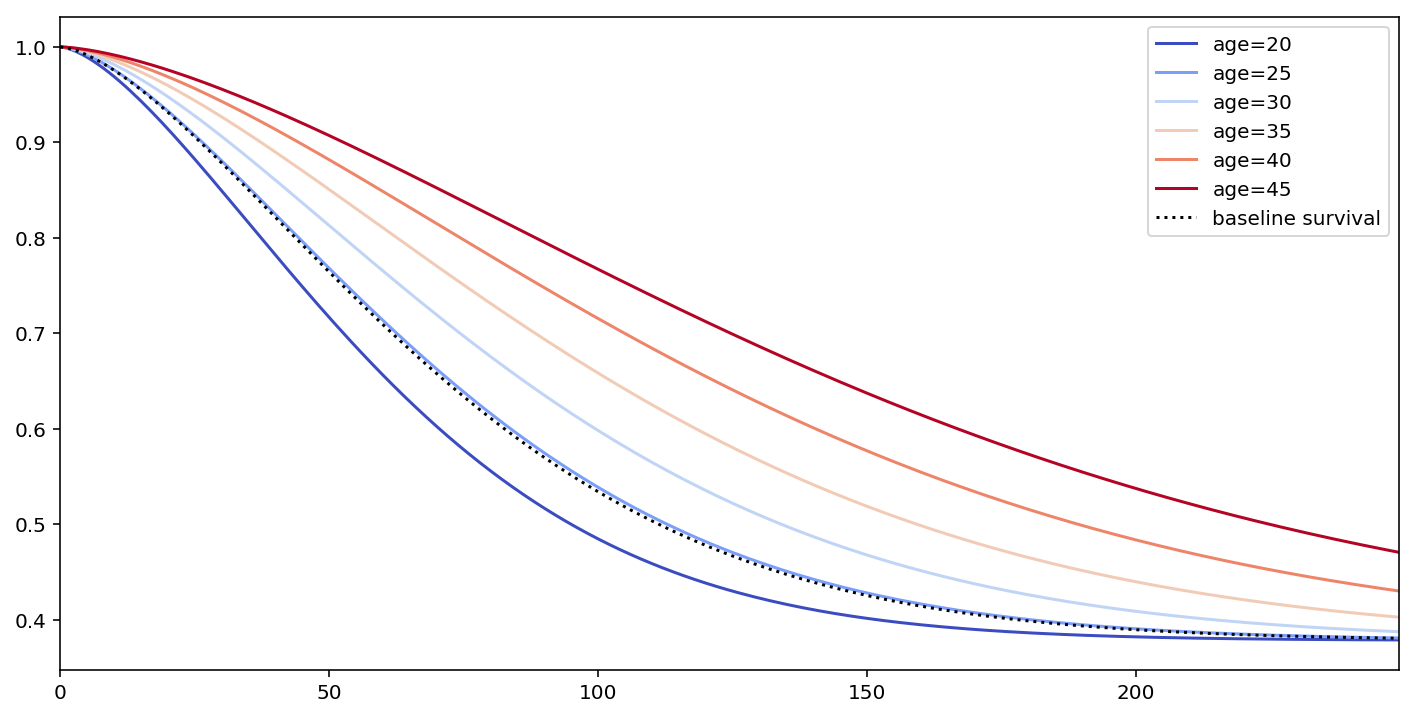

In [11]:
# what's the effect on the survival curve if I vary "age"
fig, ax = plt.subplots(figsize=(12, 6))

cm.plot_covariate_groups(['age'], values=np.arange(20, 50, 5), cmap='coolwarm', ax=ax)

### Spline models

See `royston_parmar_splines.py` in the examples folder: https://github.com/CamDavidsonPilon/lifelines/tree/master/examples